## Importing Python libraries

In [364]:
import numpy as np
import pandas as pd

#visualisations library
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scaling values
from sklearn.preprocessing import StandardScaler

# Categorical Encoding
from sklearn.preprocessing import OneHotEncoder

# Balancing the oversampling using SMOTE
from imblearn.over_sampling import SMOTE

#EDA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# Importing ML Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as Imblearn_pipeline
from sklearn.decomposition import PCA


## Loading data

In [4]:
df_app=pd.read_csv("application_record.csv", encoding='utf-8')
df_credit=pd.read_csv("credit_record.csv", encoding ='utf-8')

In [5]:
df_app.shape

(438557, 18)

In [6]:
df_credit.shape

(1048575, 3)

## Understanding Data

In [8]:
# Checking for any duplicate values
print(df_app['ID'].duplicated().sum())

df_app[df_app['ID'].duplicated()]['ID']

47


421349    7602432
422660    7052783
423702    7838075
424480    7053557
425306    7023651
425724    7213374
426198    7089090
426325    7576316
426488    7023108
426665    7137299
426714    7836711
426818    7022197
427167    7636389
427883    7207977
428048    7045794
428168    7154819
428620    7836971
428802    7416167
428986    7702238
429029    7155150
429053    7317997
429078    7036518
429104    7772847
429121    7243768
429337    7743418
429834    7090931
430187    7603224
430284    7833087
430436    7742298
430746    7050948
430756    7174719
431391    7744386
431414    7052812
431911    7022327
432088    7154598
432134    7046068
432271    7045885
432355    7636756
432379    7702516
432426    7099881
432562    7372589
432643    7024111
433158    7282535
433159    7742853
433217    7135270
433666    7091721
433789    7618285
Name: ID, dtype: int64

In [9]:
df_app[df_app['ID']==7742298]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
424819,7742298,F,N,Y,0,144000.0,Working,Secondary / secondary special,Widow,House / apartment,-20626,-1455,1,0,0,0,Cooking staff,1.0
430436,7742298,M,N,N,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-18239,-5428,1,1,0,0,NaN,2.0


In [10]:
# Serious data quality issue.
# Same ID has contrasting values for gender, property ownership, occupation, Date of birth

In [11]:
percentage_duplicate = df_app['ID'].duplicated().sum()*100/(df_app.shape[0])
print(f'Percentage of records that are duplicates :  {round(percentage_duplicate,2)} %')

Percentage of records that are duplicates :  0.01 %


In [12]:
# Its better to drop these records.

In [13]:
duplicate_ID = df_app[df_app['ID'].duplicated()]['ID']

In [14]:
df_app_new = df_app[~df_app['ID'].isin(duplicate_ID)]
df_app_new['ID'].duplicated().sum()

0

In [15]:
df_credit['ID']

0          5001711
1          5001711
2          5001711
3          5001711
4          5001712
            ...   
1048570    5150487
1048571    5150487
1048572    5150487
1048573    5150487
1048574    5150487
Name: ID, Length: 1048575, dtype: int64

In [16]:
df_credit[df_credit['ID']==5001711]

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0


In [17]:
# Here for every customer there are multiple records. Each record is for current month & the months preceding it. 
# Months_balance 0 means current month, -1 means the month before and so on. The status of every month shown.

In [18]:
df_credit['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [19]:
overdue_status = ['2', '3', '4', '5']
# 0 means due less than 29 days
# 1 means between 30 -60 days
# C means paid for the month
# X means no loan for the month.
# Other values have payment overdue > 60 days.

In [20]:
# Getting the current status
df_current_status=df_credit[df_credit['MONTHS_BALANCE']==0][['ID','STATUS']]

In [21]:
df_current_status

,ID,STATUS
0,5001711,X
4,5001712,C
23,5001713,X
45,5001714,X
60,5001715,X
...,...,...
1048451,5150481,X
1048512,5150483,X
1048530,5150484,C
1048543,5150485,0


In [22]:
# Making a dataframe to store whether the customer had defaulted ever in the payments

In [23]:
ever_default=df_credit.groupby('ID')['STATUS'].apply(
    lambda x: 1 if x.isin(['2', '3', '4', '5']).any() else 0
).reset_index(name='Ever_default')

In [24]:
ever_default.shape

(45985, 2)

In [25]:
# Creating a consolidated dataframe representing credit history of customers. Merging ever_default and current_status
df_credit_final=pd.merge(ever_default,df_current_status, on='ID')

Text(0.5, 1.0, 'Proportion of Defaulted')

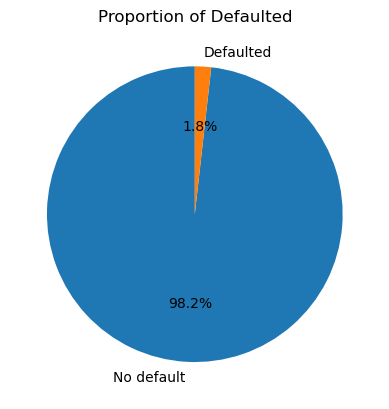

In [26]:
plt.pie(x=df_credit_final['Ever_default'].value_counts(),autopct='%1.1f%%', labels=['No default','Defaulted'], startangle=+90)
plt.title('Proportion of Defaulted')

In [27]:
df=pd.merge(df_app,df_credit_final, on='ID', how='left')

In [28]:
df.shape

(438557, 20)

In [29]:
df.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Ever_default,STATUS
326282,6296485,F,N,Y,0,405000.0,State servant,Higher education,Married,House / apartment,-19202,-5196,1,0,0,0,Managers,2.0,NaN,NaN
135008,5629017,M,N,N,1,67500.0,Working,Secondary / secondary special,Married,With parents,-15505,-249,1,1,0,0,Laborers,3.0,NaN,NaN
192897,5883297,M,Y,Y,0,360000.0,Working,Incomplete higher,Single / not married,House / apartment,-10328,-1134,1,0,0,1,Laborers,1.0,NaN,NaN
362699,6500878,F,N,Y,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-14990,-2015,1,1,1,0,NaN,3.0,NaN,NaN
205617,5919464,F,N,Y,0,67500.0,Working,Secondary / secondary special,Single / not married,Municipal apartment,-19227,-2281,1,0,0,0,Core staff,1.0,NaN,NaN


In [30]:
df['Target']=1
df['Target'][df['Ever_default']==1]=0

# If the customer has defaulted ever in the records his credit card application is rejected.
# We will predict whether the customer is granted credit card based on all columns except ['Ever_default','STATUS']

In [31]:
df.Target.value_counts(normalize=True)

Target
1    0.998739
0    0.001261
Name: proportion, dtype: float64

In [32]:
df.drop(columns=['Ever_default','STATUS'], inplace=True)

In [33]:
df.to_csv('df_final.csv', index='False')

# FEATURE ENGINEERING

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [36]:
df.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
Target                      0
dtype: int64

In [37]:
df.sample()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Target
147787,5702492,M,Y,Y,1,171000.0,Working,Secondary / secondary special,Married,House / apartment,-8500,-1073,1,0,0,0,Laborers,3.0,1


In [38]:
df_defaulted=df[df['Target']==0]
df_no_default = df[df['Target']==1]

In [39]:
dff = df.copy()

In [40]:
### Approach for Number of children and Number of family members:

# Number of children are a subset of number of family members.
# As a result it is better to drop the number of children columns as it is already represented in the number of family columns
# Also number of family columns have few outlier contributing to less than 1% data.
    #Here outliers at best can be capped at 5 members in family. All values higher than 5 are capped at 5.

In [41]:
dff['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].apply( lambda x : x if (x<=7) else 7)
print('Before Transformation\n',df.CNT_FAM_MEMBERS.describe())
print('\n\n After Transformation \n',dff.CNT_FAM_MEMBERS.describe())

Before Transformation
 count    438557.000000
mean          2.194465
std           0.897207
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


 After Transformation 
 count    438557.000000
mean          2.194221
std           0.895038
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           7.000000
Name: CNT_FAM_MEMBERS, dtype: float64


In [42]:
# Limiting occupation type to top 7 types. The left out occupations are represented as Others

major_occup = df_no_default.OCCUPATION_TYPE.value_counts().head(7).index
major_occup
dff['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].apply( lambda x:x if x in major_occup else 'Others' )

# Train Test split

In [44]:
dff = dff.drop(columns = ['CNT_CHILDREN','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE', 'FLAG_EMAIL'], axis = 1)

In [45]:
x=dff.drop(columns = ['ID','Target'], axis = 1 )
y=dff['Target']
x_train, x_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state= 42) 

### Outlier Treatment

In [47]:
# Defining a function to check for outliers. Depicts the outliers in histplot and boxplot

def outlier_check(data,col):
    plt.subplot(1,2,1)
    sns.histplot(data=data, x=col,kde=True)
    plt.axvline(x=data[col].mean(),color="red",label="Mean")
    plt.axvline(x=data[col].median(),color="green",label="Median")
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)  # nrows=1, ncols=2
    sns.boxplot(data=data, x=col)
    
    plt.subplots_adjust(right=2.0)
    plt.grid()
    plt.show()

In [48]:
# Defining a function to remove outliers using IQR method.

def outlier_treatment(data,col):
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    UW=Q3+(1.5*IQR)
    LW=Q1-(1.5*IQR)
    data[col]=data[col].clip(lower=LW, upper = UW)
    return data


In [49]:
#EDA

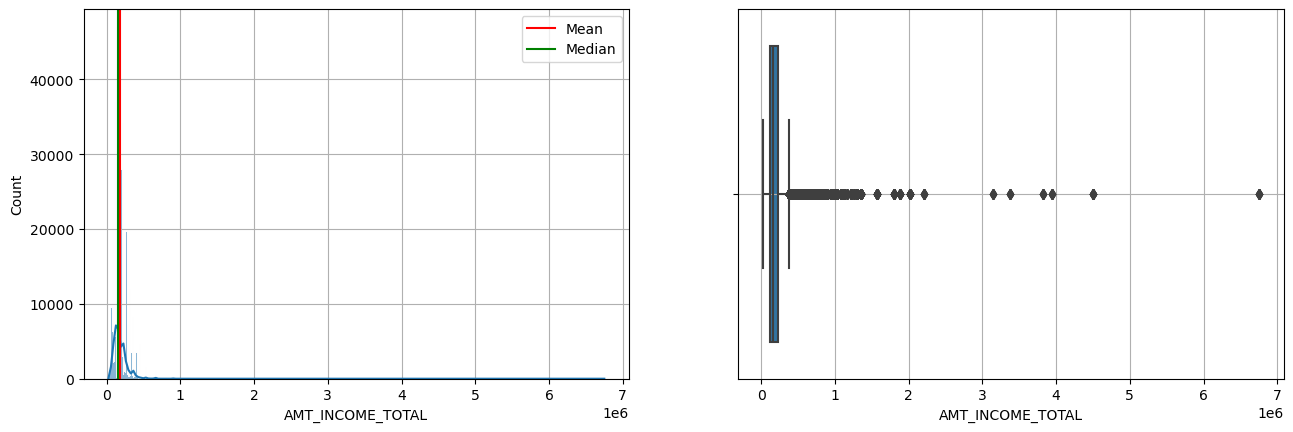

In [50]:
outlier_check(df,'AMT_INCOME_TOTAL')

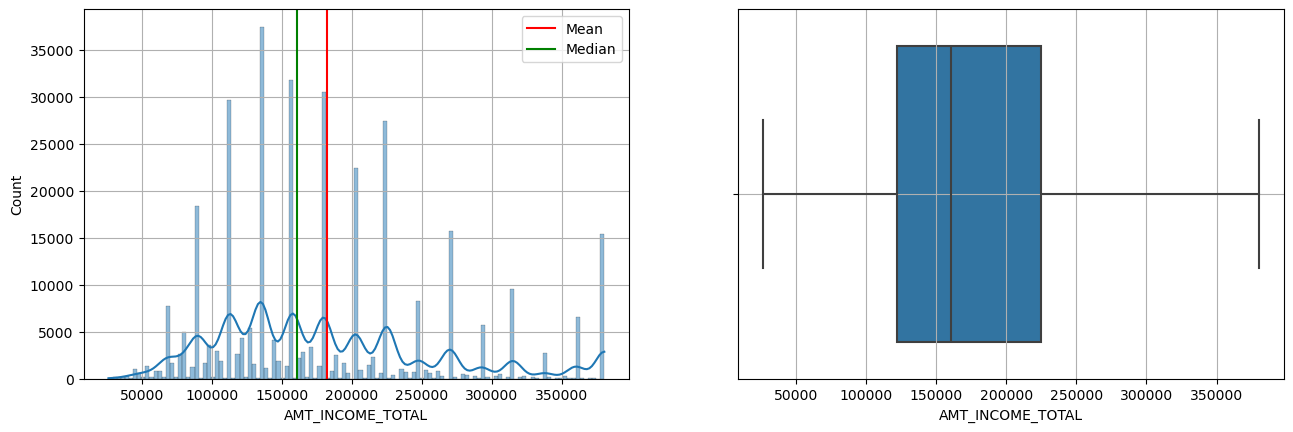

In [51]:
x_train = outlier_treatment(x_train,'AMT_INCOME_TOTAL')
outlier_check(x_train,'AMT_INCOME_TOTAL')

In [52]:
df.CNT_FAM_MEMBERS.unique()

array([ 2.,  1.,  5.,  3.,  4.,  6., 15.,  7., 20.,  9., 11., 14.,  8.])

In [53]:
# Family members cannot be a decimal number, Rounding off to nearest integer.
df['CNT_FAM_MEMBERS']=round(df.CNT_FAM_MEMBERS)

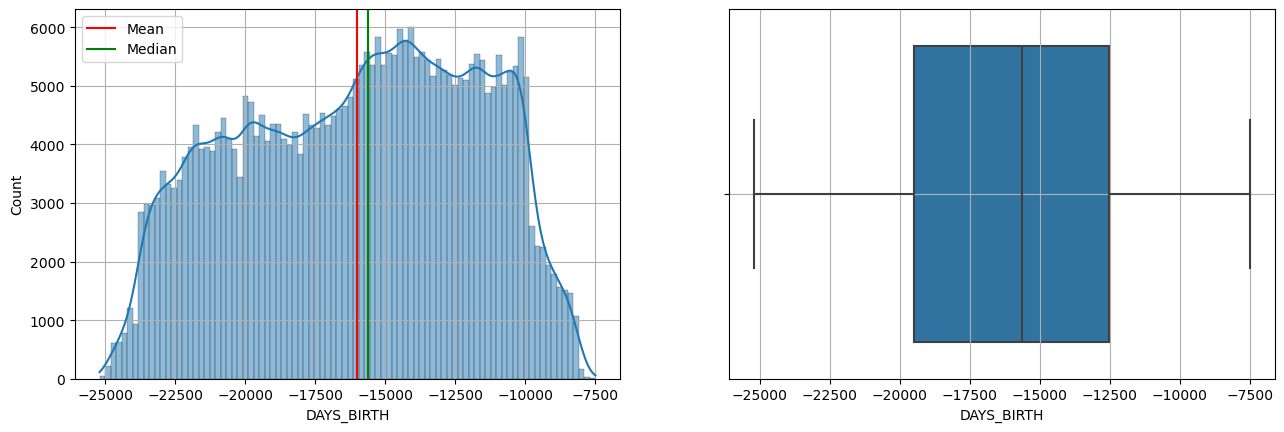

In [54]:
# Check for outliers in Age
outlier_check(x_train,'DAYS_BIRTH')

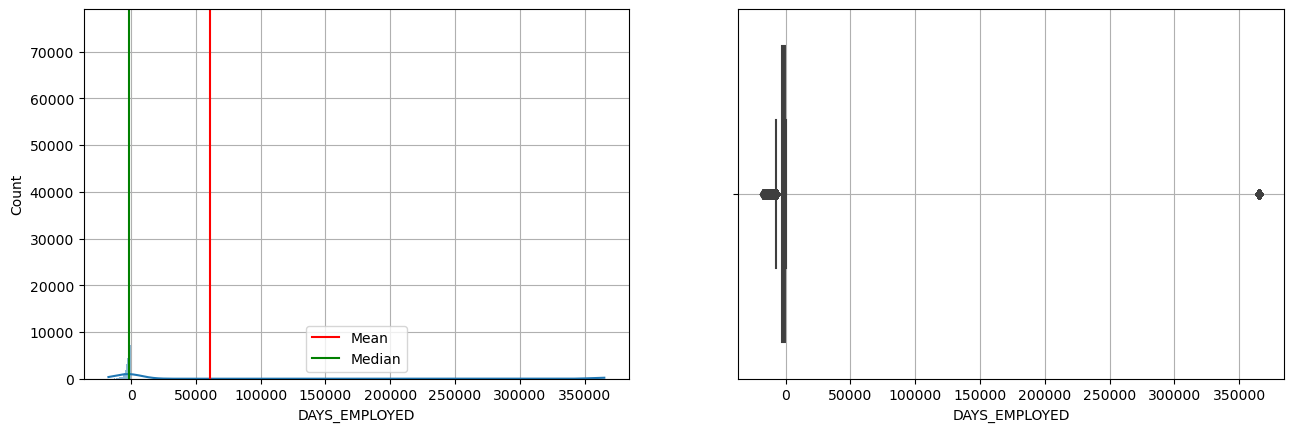

In [55]:
# Check for outliers in Experience
outlier_check(df,'DAYS_EMPLOYED')

In [56]:
# Days employed cannot be 0.35 Million  days as it would translate to 958 years. It is a data quality issue
x_train = outlier_treatment(x_train,'DAYS_EMPLOYED')

In [57]:
x_train.describe()

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,350845.000000,350845.000000,350845.000000,350845.000000
mean,181946.302955,-15996.884770,-1420.847106,2.194123
std,80798.365350,4186.960247,2964.122011,0.894680
min,26100.000000,-25201.000000,-7197.000000,1.000000
25%,121500.000000,-19486.000000,-3102.000000,2.000000
50%,160560.000000,-15629.000000,-1468.000000,2.000000
75%,225000.000000,-12509.000000,-372.000000,3.000000
max,380250.000000,-7489.000000,3723.000000,7.000000


- Converting the experience column into a categorical column by classifying the experience into 5 different categories using KBins discretisation.
- Attempting to have equal frequency bins to ensure better spread of data and outlier handling.


# Pipeline

In [60]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350845 entries, 5729 to 121958
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          350845 non-null  object 
 1   FLAG_OWN_CAR         350845 non-null  object 
 2   FLAG_OWN_REALTY      350845 non-null  object 
 3   AMT_INCOME_TOTAL     350845 non-null  float64
 4   NAME_INCOME_TYPE     350845 non-null  object 
 5   NAME_EDUCATION_TYPE  350845 non-null  object 
 6   NAME_FAMILY_STATUS   350845 non-null  object 
 7   NAME_HOUSING_TYPE    350845 non-null  object 
 8   DAYS_BIRTH           350845 non-null  int64  
 9   DAYS_EMPLOYED        350845 non-null  int64  
 10  OCCUPATION_TYPE      350845 non-null  object 
 11  CNT_FAM_MEMBERS      350845 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 34.8+ MB


In [61]:
# Initital pipeline

categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                   'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                   'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

numerical_cols = ['DAYS_BIRTH', 
                 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

KBinsCols = ['AMT_INCOME_TOTAL']

# Final Pipeline 

In [63]:

categorical_cols = ['CODE_GENDER',  'NAME_INCOME_TYPE', 
                    'NAME_FAMILY_STATUS']

numerical_cols = ['DAYS_BIRTH','DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

KBins_Income = ['AMT_INCOME_TOTAL' ]

In [64]:
# Numerical pipeline: SimpleImputer (constant) -> MinMaxScaler
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())
])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
KBins_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('Kbins', KBinsDiscretizer(encode = 'ordinal', strategy = 'quantile'))
])

<IPython.core.display.Javascript object>

In [66]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop = 'first', sparse_output=False))
])

<IPython.core.display.Javascript object>

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('KBins', KBins_pipeline,  KBins_Income),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='drop'
)


## Logistic Regression Model

In [69]:
# Complete pipeline: Preprocessor -> Logistic Regression
ml_pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression( class_weight = 'balanced'))
])

In [70]:
#  Train the model
print("Training Logistic Regression model...")
ml_pipeline_logistic.fit(x_train, y_train)
print("Model training completed!")
print()

Training Logistic Regression model...
Model training completed!



In [71]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_logistic.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [72]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")
print()


Accuracy Score: 0.4956



In [73]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.61      0.00        98
           1       1.00      0.50      0.66     87614

    accuracy                           0.50     87712
   macro avg       0.50      0.55      0.33     87712
weighted avg       1.00      0.50      0.66     87712



In [74]:
confusion_matrix(y_test, y_pred)

array([[   60,    38],
       [44207, 43407]], dtype=int64)

In [75]:
roc_auc_score(y_test,y_pred)

0.5538397087782542

In [76]:
precision_score(y_test, y_pred)

0.9991253308781217

In [77]:
# Checking for overfittng

print("Making predictions on train dataset...")
y_pred = ml_pipeline_logistic.predict(x_train)
print("Predictions completed!")
print('\n\n')
print(confusion_matrix(y_train, y_pred))
print('ROC _ AUC SCORE',roc_auc_score(y_train,y_pred))
print(precision_score(y_train,y_pred))

Making predictions on train dataset...
Predictions completed!



[[   264    191]
 [157281 193109]]
ROC _ AUC SCORE 0.5656728342578395
0.9990118986032075


In [78]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.58      0.00       455
           1       1.00      0.55      0.71    350390

    accuracy                           0.55    350845
   macro avg       0.50      0.57      0.36    350845
weighted avg       1.00      0.55      0.71    350845



In [79]:
sm = SMOTE(random_state = 42, k_neighbors = 5)

preprocessor_SMOTE = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols),
        ('KBins', KBins_pipeline,  KBins_Income)
    ],
    remainder='drop'
)


In [80]:
ml_pipeline_logistic_SMOTE = Imblearn_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', sm),
    ('classifier', LogisticRegression())
])

In [81]:
#  Train the model
print("Training Logistic Regression model for SMOTE data set...")
ml_pipeline_logistic_SMOTE.fit(x_train, y_train)
print("Model training completed!")
print()

#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_logistic_SMOTE.predict(x_test)
print("Predictions completed!")
print()

Training Logistic Regression model for SMOTE data set...
Model training completed!

Making predictions on test dataset...
Predictions completed!



In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.58      0.00        98
           1       1.00      0.52      0.68     87614

    accuracy                           0.52     87712
   macro avg       0.50      0.55      0.34     87712
weighted avg       1.00      0.52      0.68     87712



In [83]:
print(confusion_matrix(y_test,y_pred))

[[   57    41]
 [42462 45152]]


In [84]:
print(roc_auc_score(y_test,y_pred))

0.5484920404576101


In [85]:
print(precision_score(y_test,y_pred))

0.9990927798552873


## Decision Tree Model

In [87]:
# Complete pipeline: Preprocessor -> Decision Tree
ml_pipeline_decisiontree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [88]:
# Step 3: Train the model
print("Training Decision Tree model...")
ml_pipeline_decisiontree.fit(x_train, y_train)
print("Model training completed!")
print()

Training Decision Tree model...
Model training completed!



In [89]:
# Step 4: Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_decisiontree.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [90]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")
print()


Accuracy Score: 0.9983



In [91]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        98
           1       1.00      1.00      1.00     87614

    accuracy                           1.00     87712
   macro avg       0.60      0.59      0.60     87712
weighted avg       1.00      1.00      1.00     87712



In [92]:
confusion_matrix(y_test, y_pred)

array([[   18,    80],
       [   71, 87543]], dtype=int64)

In [93]:
roc_auc_score(y_test, y_pred)

0.59143154830814

                                    Feature  Importance
0                                DAYS_BIRTH    0.489919
1                             DAYS_EMPLOYED    0.261944
3                          AMT_INCOME_TOTAL    0.107746
2                           CNT_FAM_MEMBERS    0.063107
11  NAME_FAMILY_STATUS_Single / not married    0.018496
5                NAME_INCOME_TYPE_Pensioner    0.018122
9                NAME_FAMILY_STATUS_Married    0.015570
8                  NAME_INCOME_TYPE_Working    0.015128
10             NAME_FAMILY_STATUS_Separated    0.005469
4                             CODE_GENDER_M    0.003603
6            NAME_INCOME_TYPE_State servant    0.000770
12                 NAME_FAMILY_STATUS_Widow    0.000126
7                  NAME_INCOME_TYPE_Student    0.000000


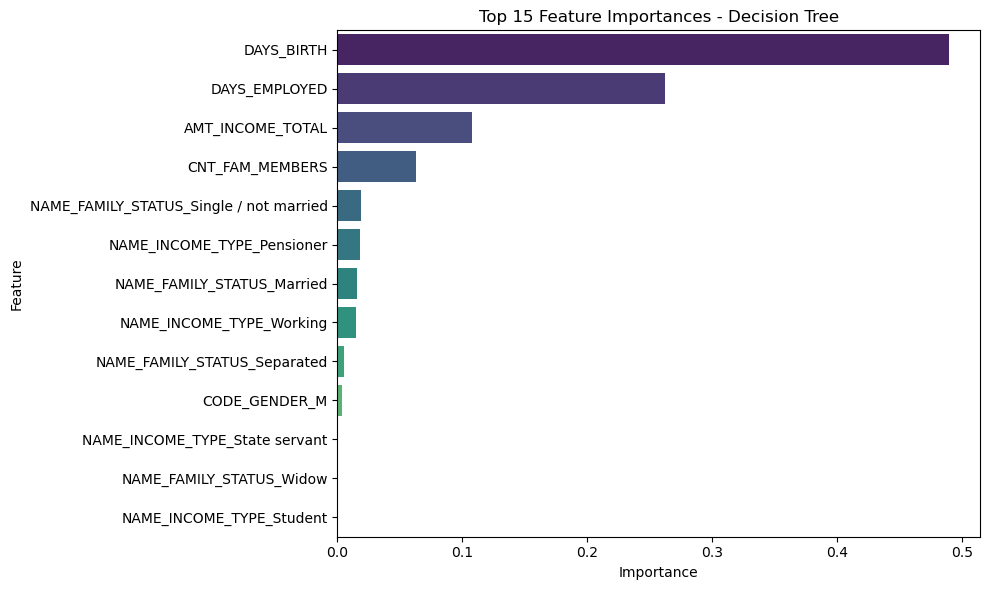

In [94]:
# Get feature names from the preprocessor
num_features = numerical_cols
kbin_features = KBinsCols

# Get categorical feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

# Combine all final feature names
all_features = np.concatenate([num_features, kbin_features, cat_features])

# Get feature importances from the trained decision tree
importances = ml_pipeline_decisiontree.named_steps['classifier'].feature_importances_

# Combine with feature names into a DataFrame
feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(15))  # Top 15 most important features

## Visualisation for feature importances

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importances.head(15),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 15 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()

In [95]:
### using SMOTE for Decision Tree

In [96]:
ml_pipeline_decisiontree_smote = Imblearn_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', sm),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [97]:
# Train the model
print("Training Decision Tree model with SMOTE...")
ml_pipeline_decisiontree_smote.fit(x_train, y_train)
print("Model training completed!")
print()

Training Decision Tree model with SMOTE...
Model training completed!



In [98]:
# Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_decisiontree_smote.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [99]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")
print()


Accuracy Score: 0.9942



In [100]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.34      0.11        98
           1       1.00      0.99      1.00     87614

    accuracy                           0.99     87712
   macro avg       0.53      0.67      0.56     87712
weighted avg       1.00      0.99      1.00     87712



In [101]:
confusion_matrix(y_test, y_pred)

array([[   33,    65],
       [  446, 87168]], dtype=int64)

In [102]:
roc_auc_score(y_test, y_pred)

0.6658220916142841

## K Neigbors

In [104]:
# Complete pipeline: Preprocessor -> K Neighbors
ml_pipeline_KNeigbors = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Kneigbors', KNeighborsClassifier(weights = 'distance'))
])

In [105]:
#  Train the model
print("Training KNeighbors model...")
ml_pipeline_KNeigbors.fit(x_train, y_train)
print("Model training completed!")
print()

Training KNeighbors model...
Model training completed!



In [106]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_KNeigbors.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [107]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")
print()


Accuracy Score: 0.9984



In [108]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.17      0.19        98
           1       1.00      1.00      1.00     87614

    accuracy                           1.00     87712
   macro avg       0.61      0.59      0.60     87712
weighted avg       1.00      1.00      1.00     87712



In [109]:
confusion_matrix(y_test, y_pred)

array([[   17,    81],
       [   63, 87551]], dtype=int64)

In [110]:
roc_auc_score(y_test, y_pred)

0.5863751622958403

In [111]:
# SMOTE FOR KNN

In [112]:
ml_pipeline_KNN_smote = Imblearn_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', sm),
    ('classifier', KNeighborsClassifier(weights = 'distance'))
])

In [113]:
#  Train the model
print("Training KNeighbors model...")
ml_pipeline_KNN_smote.fit(x_train, y_train)
print("Model training completed!")
print()

Training KNeighbors model...
Model training completed!



In [114]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_KNN_smote.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [115]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")
print()


Accuracy Score: 0.9872



In [116]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.22      0.04        98
           1       1.00      0.99      0.99     87614

    accuracy                           0.99     87712
   macro avg       0.51      0.61      0.52     87712
weighted avg       1.00      0.99      0.99     87712



In [117]:
print(confusion_matrix(y_test,y_pred))

[[   22    76]
 [ 1050 86564]]


In [118]:
roc_auc_score(y_test,y_pred)

0.6062527049306723

## Random Forest Classifier

In [120]:
# Complete pipeline: Preprocessor -> Random Forest
ml_pipeline_Random_Forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Random_Forest', RandomForestClassifier( class_weight='balanced'))
])

In [121]:
#  Train the model
print("Training Random Forest model...")
ml_pipeline_Random_Forest.fit(x_train, y_train)
print("Model training completed!")
print()

Training Random Forest model...
Model training completed!



In [122]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_Random_Forest.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [123]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.43      0.20        98
           1       1.00      1.00      1.00     87614

    accuracy                           1.00     87712
   macro avg       0.56      0.71      0.60     87712
weighted avg       1.00      1.00      1.00     87712



In [124]:
print(roc_auc_score(y_test,y_pred))

0.7126820892942746


In [125]:
print(confusion_matrix(y_test,y_pred))

[[   42    56]
 [  281 87333]]


In [126]:
# SMOTE FOR RANDOM FOREST

In [127]:
ml_pipeline_RF_SMOTE = Imblearn_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', sm),
    ('classifier', RandomForestClassifier())
])

In [128]:
#  Train the model
print("Training Random Forest model...")
ml_pipeline_RF_SMOTE.fit(x_train, y_train)
print("Model training completed!")
print()

Training Random Forest model...
Model training completed!



In [129]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_RF_SMOTE.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [130]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.29      0.10        98
           1       1.00      1.00      1.00     87614

    accuracy                           0.99     87712
   macro avg       0.53      0.64      0.55     87712
weighted avg       1.00      0.99      1.00     87712



In [131]:
print(confusion_matrix(y_test,y_pred))

[[   28    70]
 [  411 87203]]


In [132]:
print(roc_auc_score(y_test,y_pred))

0.6405116273002684


## Gradient Descend Model

In [134]:
# Complete pipeline: Preprocessor -> Gradient Descend

ml_pipeline_SGD = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SGD', SGDClassifier())
])

In [135]:
#  Train the model
print("Training SGD model...")
ml_pipeline_SGD.fit(x_train, y_train)
print("Model training completed!")
print()

Training SGD model...
Model training completed!



In [136]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_SGD.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [137]:
print(accuracy_score(y_test,y_pred))

0.9988827070412258


In [138]:
print(confusion_matrix(y_test,y_pred))

[[    0    98]
 [    0 87614]]


In [139]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       1.00      1.00      1.00     87614

    accuracy                           1.00     87712
   macro avg       0.50      0.50      0.50     87712
weighted avg       1.00      1.00      1.00     87712



In [140]:
# SMOTE on SGD
# Complete pipeline: Preprocessor -> SMOTE -> SGD
ml_pipeline_SGD_SMOTE = Imblearn_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', sm),
    ('SGD', SGDClassifier(loss="modified_huber"))
])

In [141]:
#  Train the model
print("Training SGD model for SMOTE data set...")
ml_pipeline_SGD_SMOTE.fit(x_train, y_train)
print("Model training completed!")
print()



Training SGD model for SMOTE data set...
Model training completed!



In [142]:
#  Predict on test dataset
print("Making predictions on test dataset...")
y_pred = ml_pipeline_SGD_SMOTE.predict(x_test)
print("Predictions completed!")
print()

Making predictions on test dataset...
Predictions completed!



In [143]:
print(accuracy_score(y_test,y_pred))

0.6234950747902226


In [144]:
print(confusion_matrix(y_test, y_pred))

[[   44    54]
 [32970 54644]]


In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.45      0.00        98
           1       1.00      0.62      0.77     87614

    accuracy                           0.62     87712
   macro avg       0.50      0.54      0.39     87712
weighted avg       1.00      0.62      0.77     87712



In [146]:
print(roc_auc_score(y_test,y_pred))

0.5363349348231086


In [147]:
 ml_pipeline_SGD_SMOTE

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'CNT_FAM_MEMBERS']),
                                                 ('KBins',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('Kbins',
                                                                   KBinsDiscretizer(encode='ordinal'))]),
                                                  ['AMT_INCOME_TOTAL']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CODE_GENDER',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS'])])),
                ('smote', SMOTE(random_state=42)),
                ('SGD', SGDClassifier(loss='modified_huber'))])

In [366]:
# PCA to maximise metrics

In [ ]:
recalls_score_list = []
roc_auc_list = []
no_comp = range(12,3,-1)

In [338]:
# Logistic Regression
for i in no_comp:
    ml_pipeline_logistic = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression( class_weight = 'balanced'))
    ])
    ml_pipeline_logistic.fit(x_train,y_train)
    y_pred = ml_pipeline_logistic.predict(x_test)
    recalls_score_list.append(recall_score(y_test,y_pred, average=None)[0])
    roc_auc_list.append(roc_auc_score(y_test,y_pred))


<Axes: >

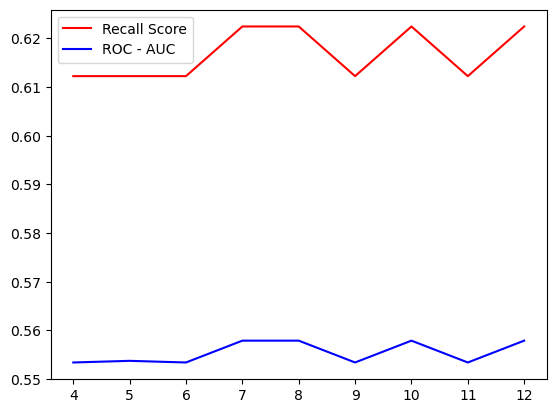

In [358]:
sns.lineplot( x =no_comp, y = recalls_score_list, label = 'Recall Score', color = 'red')
sns.lineplot( x =no_comp, y = roc_auc_list, label = 'ROC - AUC', color = 'blue' )

In [368]:
print(roc_auc_list.index(max(roc_auc_list)))

0
